# Vanilla LSTM for Sentiment Classification

This LSTM performs sentiment analysis on the IMDB review dataset.

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Dropout, Activation, SpatialDropout1D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import os
import sklearn.metrics
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Set Hyperparameters

In [2]:
output_dir = 'model_output/vanillaLSTM'

e_param = 0.006
epochs = 5
batch_size = 64
patience = 20
val_split = .2

n_dim = 256
n_unique_words = 8000
max_review_length = 300
pad_type = trunc_type = 'pre'

n_lstm = 128 
drop_lstm = 0.5

#### Load Data

In [3]:
(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

#### Preprocess Data

In [4]:
X_train = pad_sequences(X_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
X_valid = pad_sequences(X_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design Deep Net Architecture

In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(LSTM(n_lstm, dropout=drop_lstm))

model.add(Dense(1, activation='sigmoid'))

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 256)          2048000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,245,249
Trainable params: 2,245,249
Non-trainable params: 0
_________________________________________________________________


#### Configure the Model

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelCheckpoint = ModelCheckpoint(filepath=output_dir + '/best-imdb-lstm-model.hdf5', save_best_only=True, mode='min')
earlyStopping = EarlyStopping(mode='min', patience=patience)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### TensorBoard

In [9]:
tensorboard = TensorBoard("../logs/imdb-lstm-relus")

### Train the Model

In [10]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_split=val_split, callbacks=[modelCheckpoint, earlyStopping])#, tensorboard])

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 292s 15ms/step - loss: 0.4668 - acc: 0.7729 - val_loss: 0.3744 - val_acc: 0.8496
Epoch 2/5
20000/20000 [==============================] - 291s 15ms/step - loss: 0.3021 - acc: 0.8778 - val_loss: 0.3574 - val_acc: 0.8540
Epoch 3/5
20000/20000 [==============================] - 282s 14ms/step - loss: 0.2808 - acc: 0.8860 - val_loss: 0.3956 - val_acc: 0.8312
Epoch 4/5
20000/20000 [==============================] - 289s 14ms/step - loss: 0.2004 - acc: 0.9236 - val_loss: 0.3837 - val_acc: 0.8508
Epoch 5/5
20000/20000 [==============================] - 312s 16ms/step - loss: 0.2428 - acc: 0.9125 - val_loss: 0.3805 - val_acc: 0.8582


#### Evaluate

In [11]:
model = keras.models.load_model(output_dir + '/best-imdb-lstm-model.hdf5')

In [12]:
y_hat = model.predict_proba(X_valid)

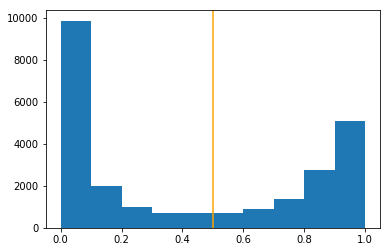

In [13]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [14]:
pct_auc = roc_auc_score(y_valid, y_hat) * 100

In [15]:
'{:0.2f}'.format(pct_auc)

'93.23'

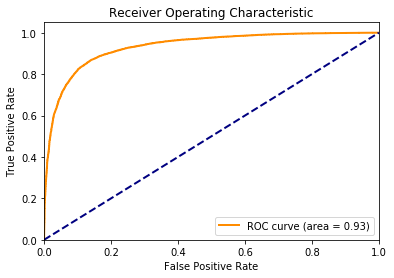

In [16]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_valid, y_hat)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()